# Seattle Library Online Checkouts in the time of COVID-19

### <center>*Null Hypothesis:* The rate of change for online checkouts did not increase in March 2020.</center>

### Import the Data from the [Seattle Open Data API](https://data.seattle.gov/Community/Checkouts-by-Title/tmmm-ytt6)
[Library Checkouts by Title Data Set FAQs](file:///Users/bethany.lindsey/Downloads/Checkouts_by_Title_FAQs%20(2).pdf) 

In [2]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import matplotlib.pyplot as plt 
import scipy.stats as stats

%matplotlib inline

plt.style.use('ggplot')

In [6]:

client = Socrata('data.seattle.gov',
                  app_token='Insert Your App Token')

results = client.get('tmmm-ytt6', select="usageclass, checkoutyear, checkoutmonth, checkouts, checkouttype", where='checkoutyear>=2018 AND usageclass="Digital"', limit = 10000000)

In [7]:
len(results)

2151128

### Moving Library API Results into Pandas DataFrame

In [8]:
library_df = pd.DataFrame.from_records(results)

In [9]:
library_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2151128 entries, 0 to 2151127
Data columns (total 5 columns):
checkoutmonth    object
checkouts        object
checkouttype     object
checkoutyear     object
usageclass       object
dtypes: object(5)
memory usage: 82.1+ MB


In [49]:
library_df = library_df.astype({'checkouts': 'int64','checkoutmonth': 'int64','checkoutyear': 'int64' }, inplace=True)

In [50]:
library_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2151128 entries, 0 to 2151127
Data columns (total 5 columns):
checkoutmonth    int64
checkouts        int64
checkouttype     object
checkoutyear     int64
usageclass       object
dtypes: int64(3), object(2)
memory usage: 82.1+ MB


### Additional Pull to get 2016, 2017 Data

In [183]:
client = Socrata('data.seattle.gov',
                  app_token='Insert Your App Token')

results2 = client.get('tmmm-ytt6', select="usageclass, checkoutyear, checkoutmonth, checkouts, checkouttype", where='checkoutyear BETWEEN 2016 AND 2017 AND usageclass="Digital"', limit = 10000000)

In [184]:
library_df2 = pd.DataFrame.from_records(results2)

In [185]:
library_df2 = library_df2.astype({'checkouts': 'int64','checkoutmonth': 'int64','checkoutyear': 'int64'}, inplace=True)

In [186]:
#Combining both pulls into one dataframe
library_combined = pd.concat([library_df, library_df2])

In [228]:
#Saving data file out to a local machine
library_combined.to_csv('~/galvanize/capstone/capstone_one/library_combined.csv')

In [7]:
#Load data from the local csv file
library_df_combined= pd.read_csv('~/galvanize/capstone/capstone_one/library_combined.csv', index_col=0) 

### Creating the Dataframe for Analysis

In [8]:
#Group by year and month and sum checkouts, then sort into chronlogical order    
ckouts_per_month_type = library_df_combined.groupby(['checkouttype','checkoutyear', 'checkoutmonth']).sum()
ckouts_per_month_type = ckouts_per_month_type.sort_values(by=['checkouttype','checkoutyear', 'checkoutmonth'])
ckouts_per_month_type.reset_index(inplace=True)


#Isolate checkout type to Overdrive and set index 
OD_ckouts = ckouts_per_month_type[ckouts_per_month_type['checkouttype']=='OverDrive']
OD_ckouts.set_index(np.arange(0,len(OD_ckouts),1), inplace=True)

#Create a new colum with the increase in online checkouts month over month 
OD_ckouts = pd.DataFrame(OD_ckouts)
OD_sum_list = list(OD_ckouts['checkouts'])
OD_rates = []

#Calculating the rate of change from month to month
for i in range(len(OD_sum_list)-1):
    rate = (OD_sum_list[i+1]/OD_sum_list[i])-1
    OD_rates.append(rate)
    
OD_rates.insert(0,0)
OD_ckouts['Rate of Change'] = OD_rates

In [6]:
OD_ckouts.head(10)

,checkouttype,checkoutyear,checkoutmonth,checkouts,Rate of Change
0,OverDrive,2016,1,165312,0.000000
1,OverDrive,2016,2,154088,-0.067896
2,OverDrive,2016,3,165164,0.071881
3,OverDrive,2016,4,161423,-0.022650
4,OverDrive,2016,5,168296,0.042578
5,OverDrive,2016,6,167416,-0.005229
6,OverDrive,2016,7,176392,0.053615
7,OverDrive,2016,8,179073,0.015199
8,OverDrive,2016,9,169489,-0.053520
9,OverDrive,2016,10,169215,-0.001617


### Getting the Test Statistics 

In [9]:
#Mean of rates of change not including March 2020
OD_mean = OD_ckouts.iloc[0:49,4].mean()

In [10]:
#Standard deviation not including March 2020
OD_std = OD_ckouts.iloc[0:49,4].std()

In [11]:
#Rate of Change for March 2020
OD_March_2020 = OD_ckouts.iloc[50,4]

### Plots for Analysis

This plot demonstrates the increase in digital checkouts via Overdrive at the Library over time.   

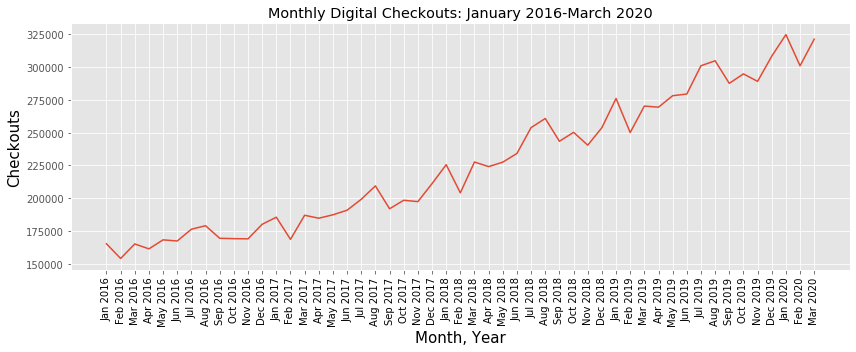

In [25]:
fig, ax = plt.subplots(figsize=(12,5))


#Creating a list for the x_ticks 
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
years = [2016, 2017, 2018, 2019, 2020] 
l = []
for y in range(len(years)):
    for m in range(len(months)):
        my = str(months[m]+" "+ str(years[y]))
        l.append(my)
dates_axis = l[:51]

#Drawing the plot
ax.set_title('Monthly Digital Checkouts: January 2016-March 2020')
ax.set_xlabel('Month, Year', size = 15, color='black')
ax.set_ylabel('Checkouts', size=15, color='black')
ax.plot(OD_ckouts.index, OD_ckouts['checkouts'])
ax.set_xticks(OD_ckouts.index)
ax.set_xticklabels(dates_axis, rotation='vertical', color='black')
fig.tight_layout() 

fig.savefig('monthly_ckouts.png')

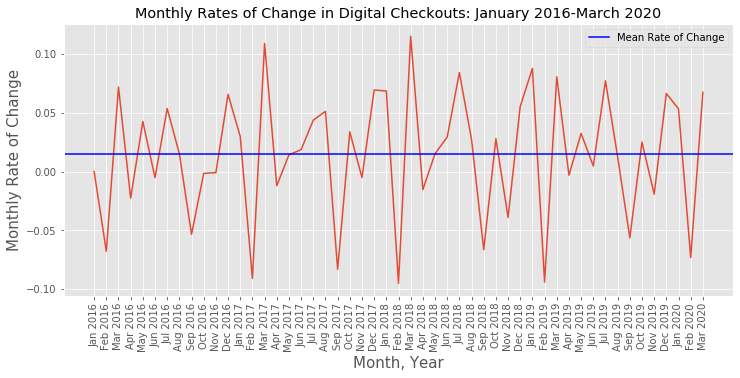

In [26]:
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.set_title('Monthly Rates of Change in Digital Checkouts: January 2016-March 2020')
ax1.set_xlabel('Month, Year', size= 15)
ax1.set_ylabel('Monthly Rate of Change', size=15) 
ax1.plot(OD_ckouts.index, OD_ckouts['Rate of Change'])
ax1.axhline(OD_mean, label='Mean Rate of Change', color='b')
ax1.set_xticks(OD_ckouts.index)
ax1.set_xticklabels(dates_axis, rotation='vertical')
plt.legend()

fig.savefig('monthly_ckouts_rates.png')

This plot above shows the rate of change in online checkouts from month to month.

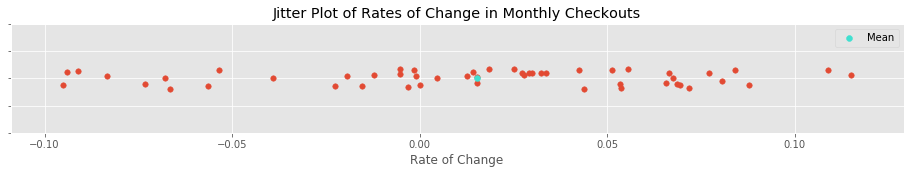

In [27]:
#function to create the jitter plot
def one_dim_scatterplot(data, ax, jitter=0.2, **options):
    if jitter:
        jitter = np.random.uniform(-jitter, jitter, size=data.shape)
    else:
        jitter = np.repeat(0.0, len(data))
    ax.scatter(data, jitter, **options)
    ax.yaxis.set_ticklabels([])
    ax.set_ylim([-1, 1]) 

#Drawing the plot
data = OD_ckouts['Rate of Change']
fig, ax = plt.subplots(figsize=(16, 2))
ax.set_title('Jitter Plot of Rates of Change in Monthly Checkouts')
one_dim_scatterplot(data, ax, s=30)
ax.set_xlabel('Rate of Change')
ax.scatter(OD_mean,0, s=35, color='turquoise', label='Mean')

ax.legend()
fig.savefig('ckouts_rates_jitter.png')

This jitter plot above provides a sense of the distribution of the rates of change. The rates of changes appear to fall into a normal distribution with most of falling in the range nearer to mean with outliers at either end.   




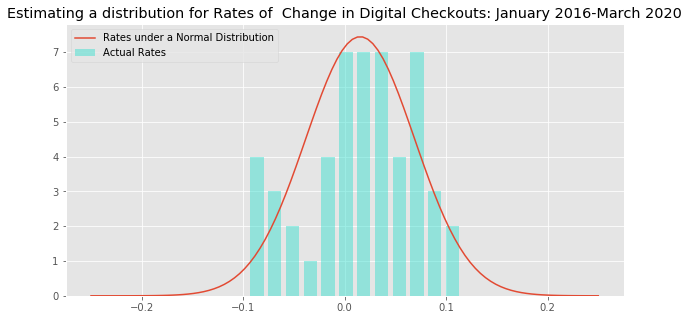

In [28]:
fig, ax = plt.subplots(figsize=(10,5))

OD_norm = stats.norm(OD_mean, OD_std)
x = np.linspace(-.25,.25,100)

ax.set_title('Estimating a distribution for Rates of  Change in Digital Checkouts: January 2016-March 2020')
ax.plot(x, OD_norm.pdf(x), label = 'Rates under a Normal Distribution')
ax.hist(OD_ckouts['Rate of Change'].sort_values(), bins=12 , color='turquoise', label='Actual Rates', rwidth=.75, alpha=.5)

ax.legend(loc='best')
fig.savefig('ckouts_rates_hist.png')


The plot above give another perspective on the distribution of the rates of change. Again the rates appear to fall into a normal distribution. 

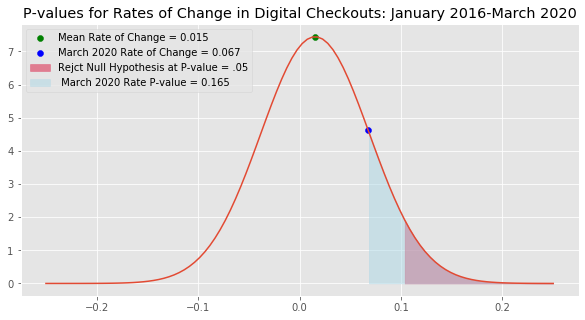

In [29]:
fig, ax = plt.subplots(figsize=(10,5))

OD_norm = stats.norm(OD_mean, OD_std)
x = np.linspace(-.25,.25,100)

ax.set_title('P-values for Rates of Change in Digital Checkouts: January 2016-March 2020')
ax.scatter(OD_mean, OD_norm.pdf(OD_mean), color='g', label='Mean Rate of Change = {:2.3f}'.format(OD_norm.ppf(.5)))
ax.plot(x, OD_norm.pdf(x))
ax.scatter(OD_March_2020, OD_norm.pdf(OD_March_2020), color='blue', label ='March 2020 Rate of Change = {:2.3f}'.format(OD_March_2020))
ax.fill_between(x, OD_norm.pdf(x), 
                where=(x >= OD_norm.ppf(.95)), color="crimson", alpha=0.5, label='Rejct Null Hypothesis at P-value = .05')
ax.fill_between(x, OD_norm.pdf(x), 
                where=(x >= OD_March_2020), color="lightblue", alpha=0.5, label=' March 2020 Rate P-value = {:2.3f}'.format(1-OD_norm.cdf(OD_March_2020)))

ax.legend(loc='best')

fig.savefig('monthly_ckouts_pval.png')

The plot shows the rates of change plotted onto a normal distribution. If the March 2020 rate of change would have fallen into the shaded area equaling $\alpha = 0.05$ or greater, we have been able to reject the null hypothesis.  Because the p-value is above the threshold, we fail to reject the null hypothesis. 